# Analysis of losses due to trailing

## Analytic Trailed Profile Computation

### Trailed point source profile

The image of a point source on the camera located at position $(x_c, y_c)$ is formed as follows:

$F(x, y; x_c, y_c, T, C) = \frac{C}{T} \int_0^T \Phi(x - x_c, y - y_c) dt$

where $C$ is the total number of counts for the source (integrated over the PSF), the $T$ is the exposure time, and $\Phi$ is the unit-normalized point spread function. As expected, this simply integrates to $C * \Phi(x - x_c, y - y_c)$.

Assuming the source moves along the $x$ axis with velocity $v$, we have:

$x_c(t) = x_0 + v t$

and therefore:

$F(x, y; x_0, y_0, v, T, C) = \frac{C}{T} \int_0^T \Phi(x - x_0 - vt, y - y_c) dt$

If $\Phi(x, y)$ is separable (e.g., the PSF is a 2D Gaussian), we can take the $y$-dependent part outside the integral, leaving us with:

$F(x, y; x_0, y_0, v, T, C) = \frac{C}{T} \Phi_y(y - y_c) \int_0^T \Phi_x(x - x_0 - vt) dt$

Substituting $w = x - x_0 - vt$, we get:

$F(x, y; x_0, y_0, v, T, C) = - \frac{C}{v T} \Phi_y(y - y_c) \int_{x-x_0}^{x - x_0 - v T} \Phi_x(w) dw$

. With $\Phi_x(x) = N(x; 0, \sigma)$ this integrates to:

$F(x, y; x_0, y_0, v, T, \sigma) = \frac{C}{2 v T} \Phi_y(y - y_c) \left[ {\mathrm erf}(\frac{x-x_0}{\sqrt{2}\sigma}) - {\mathrm erf}(\frac{x-x_0-vT}{\sqrt{2}\sigma})\right]$

### Trailed point source profile in likelihood images

The above is equivalent to a convolution of a line segment spanning $[x_0, x_0 + v T]$ with the PSF, $\Phi(x, y)$. Proof:

$\int_{x_1}^{x_2} \Phi(w) dw = \int_{-\inf}^{\inf} \left[ H(w - x_1) - H (w - x_2) \right] \Phi(w) dx$

with $x_1 = x - x_0$ and $x_2 = x - x_0 - v T$. If we define 

$L(x) \equiv H(x - x_0) - H(x - (x_0 + vT))$,

we find that:

$F(x, y; x_0, y_0, v, T, \sigma) = \frac{C}{v T} \Phi_y(y - y_c) (L * \Phi_x)(x)$

This identity is useful when we consider how detection is done. We detect by correlating the image with the PSF, $\Phi(x, y)$, which is equivalent to convolving with $\Phi(-x, -y)$. Assuming the PSF is symmetric:

$F \star \Phi$ = $F \ast \Phi$ = $\frac{C}{v T} (\Phi_y \ast \Phi_y)(y - y_c) \times (L \ast \Phi_x \ast \Phi_x)(x)$

and, finally, assuming $\Phi_x$ and $\Phi_y$ are Gaussian:

$(\Phi_x \ast \Phi_x)(x; \mu, \sigma) = \Phi_x(x; \mu, \sqrt(2)\sigma)$

In other words, if the PSF is separable and Gaussian, the trailed source retains the same profile in the likelihood image, just $\sqrt 2$ broader.

### Generalization

This generalizes to a separable PSF that is a sum of Gaussians (though care must be taken to take into account all terms when, e.g., $(\Phi_x \ast \Phi_x)$ is computed, for the likelihood (detection) image. This generalization has not been implemented here; the rest of this notebook works with a simple Gaussian.

## Implementation

In [12]:
%matplotlib inline

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

from scipy.special import erf
from scipy.stats import norm

In [13]:
# Trail profile in a single exposure, assuming Gaussian PSF, following the derivation above
# The time T is the exposure time.
def snap_trail(x, y, sigma, x0, v, T):
    scale = np.sqrt(2.) * sigma

    psf_y = norm(loc=0, scale=sigma).pdf

    z1 = (x - x0)       / scale
    z2 = (x - x0 - v*T) / scale

    return 1./(2.*v*T) * (erf(z1) - erf(z2)) * psf_y(y)

# Trail profile for the visit
# The time T is the exposure time for *one snap*, not the entire visit.
def visit_trail(x, y, sigma, x0, v, T, Tpause):

    snap1 = snap_trail(x, y, sigma, x0,                v, T)
    snap2 = snap_trail(x, y, sigma, x0 + v*(T+Tpause), v, T)
    
    return 0.5*(snap1 + snap2)

def psf1d(x, sigma):
    # 1D PSF
    return norm(loc=0, scale=sigma).pdf(x)

def psf(x, y, sigma):
    return psf1d(x, sigma)*psf1d(y, sigma)

Let's visualize some of this:

0.06 "/sec Flux ratio in the center: 0.33


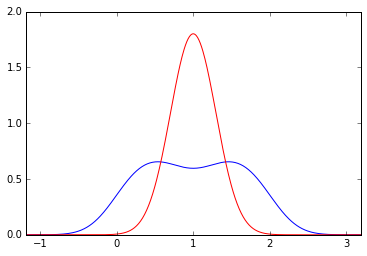

In [89]:
x0 = 0              # position of the start of the trail
v = 1.5/24.          # velocity, in arcsec/sec (note: to convert deg/day -> "/sec just divide by 24)
T = 15              # exposure time of one *snap*
Tpause = 2          # time between snaps
FWHM = .7           # FWHM of the PSF (multiply by sqrt(2) to get likelihood image equivalent)

sigma = FWHM / (2. * np.sqrt(2. * np.log(2)))

# Trailed source profile
x = np.linspace(x0 - 4*sigma, x0 + v*(2*T+Tpause) + 4*sigma, 500)
xt = visit_trail(x, 0, sigma, x0, v, T, Tpause)
plt.plot(x, xt)

# Comparison with stationary object centered at mid-exposure
xc = x0 + v*(T+Tpause/2.)
plt.plot(x, psf(x - xc, 0, sigma), color='red')
plt.xlim(x.min(), x.max())

print '%.2f "/sec' % v, "Flux ratio in the center: %.2f" % (np.interp(xc, x, xt) / psf(0, 0, sigma))

The integral should equal approximately 1:  0.999954229536


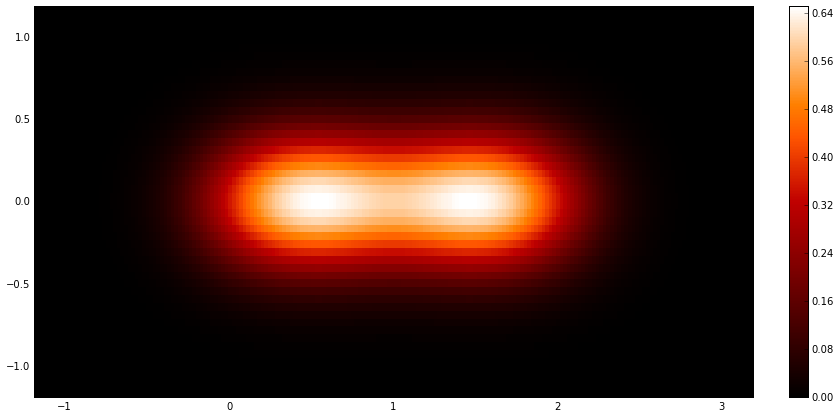

In [15]:
# 2D plot of the shape
xaxis = np.linspace(x0 - 4*sigma, x0 + v*(2*T+Tpause) + 4*sigma, 200)
yaxis = np.linspace(   - 4*sigma,                       4*sigma, 50)
fval = visit_trail(xaxis[:, None], yaxis[None, :], sigma, x0, v, T, Tpause)

plt.figure(figsize=(16, 7))
extent = [xaxis[0], xaxis[-1], yaxis[0], yaxis[-1] ]
im = plt.imshow(fval.T, origin='lower', extent=extent, interpolation='nearest', cmap='gist_heat')
plt.colorbar(im, fraction=0.046, pad=0.04)

# Sanity check: Integrate and check we got about 1
fluxTotal = fval.sum()*(xaxis[1]-xaxis[0])*(yaxis[1]-yaxis[0])
print "The integral should equal approximately 1: ", fluxTotal

## Test correctness against numerical computation

Ratio of peak pixel counts (moving vs. static, v=2.00 deg/day): 0.38


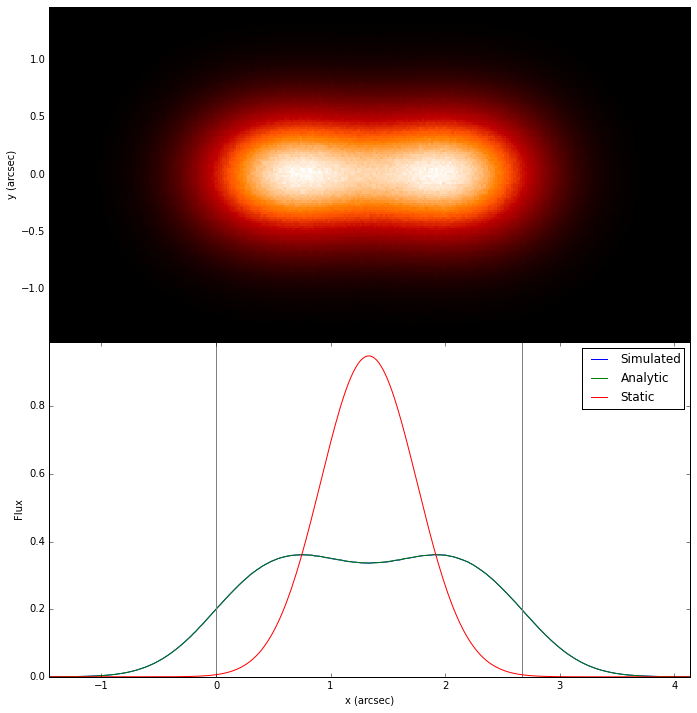

In [102]:
x0 = 0              # position of the start of the trail
v = 2./24.          # velocity, in arcsec/sec (note: to convert deg/day -> "/sec just divide by 24)
T = 15              # exposure time of one *snap*
Tpause = 2          # time between snaps
FWHM = .7           # FWHM of the PSF (multiply by sqrt(2) to get likelihood image equivalent)

detect = True       # set to True if generating likelihood image

dx = 0.02           # Binning pixel scale (x direction)
dy = 0.02           # Binning pixel scale (y direction)

N = 100*1000*1000    # Number of counts (in a visit)

## Computed constants

sigma  = FWHM / (2. * np.sqrt(2. * np.log(2)))
sigmaA = sigma*np.sqrt(2.) if detect else sigma    # The width of the kernel to convolve with for detection

## ---

# Simulate a trailed source
def imsim_trail(N, dx, dy, detect):
    # compute reasonable bin edges, keeping the center of trail in the center of a pixel
    xedges = np.arange(np.round((x0 - 5*sigma)/dx), np.round((x0 + v*(2*T+Tpause) + 5*sigma)/dx), 1)*dx + 0.5*dx
    yedges = np.arange(np.round((   - 5*sigma)/dy), np.round((                      5*sigma)/dy), 1)*dy + 0.5*dy

    def sample_snap(N, x0, v, T, detect):
        # Moving object above the atmosphere (line)
        x = rnd.uniform(x0, x0 + v*T, N)

        # Convolution with seeing
        x += rnd.normal(loc=0, scale=sigma, size=N)
        y  = rnd.normal(loc=0, scale=sigma, size=N)

        if detect:
            # Correlation with the PSF (for detection)
            x += rnd.normal(loc=0, scale=sigma, size=N)
            y += rnd.normal(loc=0, scale=sigma, size=N)

        return x, y

    # Combine the two snaps & histogram
    x1, y1 = sample_snap(N/2, x0,                  v, T, detect)
    x2, y2 = sample_snap(N/2, x0 + v*(T + Tpause), v, T, detect)
    x = np.hstack((x1, x2))
    y = np.hstack((y1, y2))
    foot, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])

    return foot, xedges, yedges

# 2D trail via sampling
foot, xedges, yedges = imsim_trail(N, dx, dy, detect)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(11.5,12))
im = ax1.imshow(foot.T / foot.max(), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest', cmap='gist_heat')
ax1.set_ylabel("y (arcsec)")
#plt.colorbar(im, fraction=0.046, pad=0.04, ax=ax1)

#
# 1D histograms along the x axis (marginalized over y!)
#
foot1d = foot.sum(axis=1) / float(N) / dx
bins = (xedges[:-1] + xedges[1:]) / 2.
l1 = ax2.plot(bins, foot1d, label="Simulated")
#
# Overplot analytic solution
#
xt = visit_trail(bins, 0, sigmaA, x0, v, T, Tpause) / psf1d(0, sigmaA)
l2 = ax2.plot(bins, xt, label="Analytic")
#
# Overplot comparison with stationary object centered at mid-exposure
#
ax2.axvline(x=x0, color='gray')
ax2.axvline(x=x0 + v*(2*T + Tpause), color='gray')
xc = x0 + v*(T + Tpause/2.)
l3 = ax2.plot(bins, psf1d(bins - xc, sigmaA), color='red', label="Static")
ax2.set_xlim(bins.min(), bins.max())
ax2.set_ylim(0, 0.99)
ax2.set_xlabel("x (arcsec)")
ax2.set_ylabel("Flux")
ax2.legend()

fig.subplots_adjust(hspace=0)

# Peak pixel ratio of static vs moving source
print "Ratio of peak pixel counts (moving vs. static, v=%.2f deg/day): %.2f" % (v*24, xt.max() / psf1d(bins - xc, sigmaA).max())

## Sensitivity loss due to trailing


Losses at various velocities (deg/day), FWHM=0.70:
v=0.00:  -0.00 mag
v=0.20:  -0.02 mag
v=0.50:  -0.12 mag
v=1.00:  -0.42 mag
v=2.00:  -1.05 mag


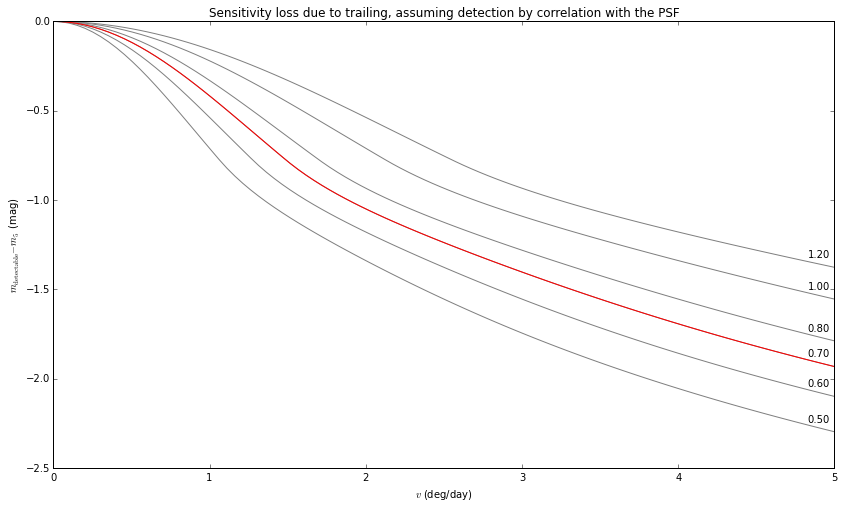

In [136]:
# Compute change in detectable magnitude vs. object velocity

def delta_mag(sigma, x0, v, T, Tpause, detect):
    sigmaA = sigma*np.sqrt(2.) if detect else sigma

    def peak_trailed_flux(v):
        # Trail flux along y=0 line (well sampled)
        x = np.linspace(x0, x0 + v*(2*T+Tpause), 200)
        xt = visit_trail(x, 0, sigmaA, x0, v, T, Tpause)
        return xt.max()

    if np.isscalar(v):
        res = peak_trailed_flux(v)
    else:
        res = np.asarray([peak_trailed_flux(v) for v in np.asarray(v)])

    psfPeak = norm(loc=0, scale=sigmaA).pdf(0) ** 2.    # Static source peak flux
    return -2.5 * np.log10( psfPeak / res )
    #return psfPeak / res

plt.figure(figsize=(14, 8))

# sensitivity loss curve
varr = np.linspace(0.001,5,100)/24
#Tpause = 2
for FWHM in [ .5, .6, .8, 1, 1.2,    .7 ]:
    dmag = delta_mag(FWHM / (2. * np.sqrt(2. * np.log(2))), x0, varr, T, Tpause, detect=True)
    plt.plot(varr*24, dmag, c='grey')
    plt.annotate("%.2f" % FWHM, (varr[-1]*24, dmag[-1]),
                 horizontalalignment='right', verticalalignment='bottom',
                 xytext=(-5, 8), textcoords='offset points',)

# plot
plt.plot(varr*24, dmag, c='red')
plt.xlabel("$v$ (deg/day)")
plt.ylabel(r"$m_{\rm detectable} - m_5$ (mag)")
plt.title("Sensitivity loss due to trailing, assuming detection by correlation with the PSF")

# print a few results
print "\nLosses at various velocities (deg/day), FWHM=%.2f:" % FWHM
print "=================================================="
for v in [0.001, 0.2, 0.5, 1, 2]:
    print "v=%.2f:  %.2f mag" % (v, np.interp(v, varr*24, dmag))

Maximum difference (fitting func. vs true): 0.023 mag
Polynomial fit coefficients: ['2.91', '-528.74', '6237.04', '-29651.44', '50687.66']


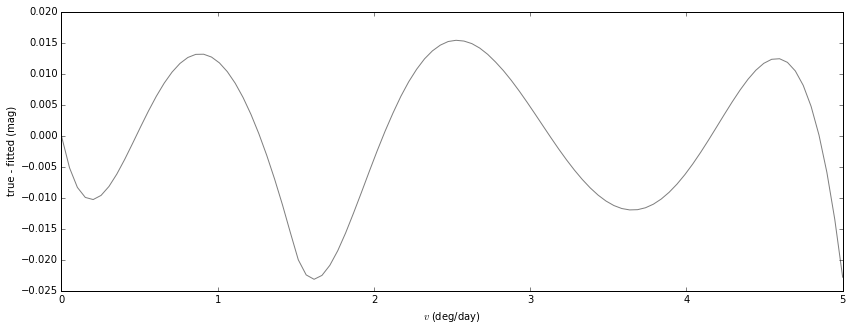

In [137]:
# derive a fitting formula
from scipy.optimize import curve_fit
def fnc(x, b, c, d, e, f):
    return b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5
popt, pcov = curve_fit(fnc, varr, dmag)
print "Maximum difference (fitting func. vs true): %.3f mag" % np.max(fnc(varr, *popt) - dmag)

# See how well we've done
plt.figure(figsize=(14, 5))
plt.plot(varr*24, dmag - fnc(varr, *popt), c='gray')
plt.xlabel("$v$ (deg/day)")
plt.ylabel(r"true - fitted (mag)")

# print the coefficients
print 'Polynomial fit coefficients:', [ '%.2f' % ii for ii in [0] + popt ]

In [29]:
.2/24*32/.2

1.3333333333333333

In [119]:
erf(0)

0.0

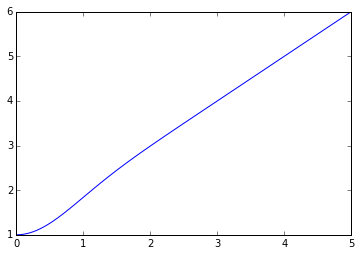

In [135]:
xx = np.linspace(0, 5, 100)
plt.plot(xx, 1 + xx * erf(xx))